In [ ]:
import sys
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, MinMaxScaler,StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from google.colab import drive

warnings.filterwarnings('ignore')

In [ ]:
# Mount Google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
rl=pd.read_csv('/content/drive/MyDrive/Datasets/nearest-earth-objects(1910-2024).csv', low_memory=False)
rl = pd.DataFrame(rl)


In [ ]:
rl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338199 entries, 0 to 338198
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   neo_id                  338199 non-null  int64  
 1   name                    338199 non-null  object 
 2   absolute_magnitude      338171 non-null  float64
 3   estimated_diameter_min  338171 non-null  float64
 4   estimated_diameter_max  338171 non-null  float64
 5   orbiting_body           338199 non-null  object 
 6   relative_velocity       338199 non-null  float64
 7   miss_distance           338199 non-null  float64
 8   is_hazardous            338199 non-null  bool   
dtypes: bool(1), float64(5), int64(1), object(2)
memory usage: 21.0+ MB


In [ ]:
rl.nunique()

,0
neo_id,33514
name,33514
absolute_magnitude,1778
estimated_diameter_min,1778
estimated_diameter_max,1778
orbiting_body,1
relative_velocity,338189
miss_distance,337826
is_hazardous,2


In [ ]:
rl_1 = rl.drop(columns=['neo_id', 'name','orbiting_body'])

In [ ]:
# rl['is_hazardous'] = rl['is_hazardous'].map({'False': 0, 'True': 1})
le = LabelEncoder()
rl_1['is_hazardous'] = le.fit_transform(rl_1['is_hazardous'])
scaler = MinMaxScaler()
rl_1['miss_distance'] = scaler.fit_transform(rl_1[['miss_distance']])
rl_1['relative_velocity'] = scaler.fit_transform(rl_1[['relative_velocity']])

In [ ]:
rl_1

,absolute_magnitude,estimated_diameter_min,estimated_diameter_max,relative_velocity,miss_distance,is_hazardous
0,19.140,0.394962,0.883161,0.245362,0.777315,0
1,18.500,0.530341,1.185878,0.376388,0.745994,1
2,21.450,0.136319,0.304818,0.084582,0.898495,0
3,20.630,0.198863,0.444672,0.269865,0.406323,0
4,22.700,0.076658,0.171412,0.191486,0.843833,0
...,...,...,...,...,...,...
338194,28.580,0.005112,0.011430,0.193580,0.856493,0
338195,28.690,0.004859,0.010865,0.071773,0.394188,0
338196,21.919,0.109839,0.245607,0.039882,0.714704,0
338197,23.887,0.044377,0.099229,0.192042,0.069232,0


In [ ]:
rl_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338199 entries, 0 to 338198
Data columns (total 6 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   absolute_magnitude      338171 non-null  float64
 1   estimated_diameter_min  338171 non-null  float64
 2   estimated_diameter_max  338171 non-null  float64
 3   relative_velocity       338199 non-null  float64
 4   miss_distance           338199 non-null  float64
 5   is_hazardous            338199 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 15.5 MB


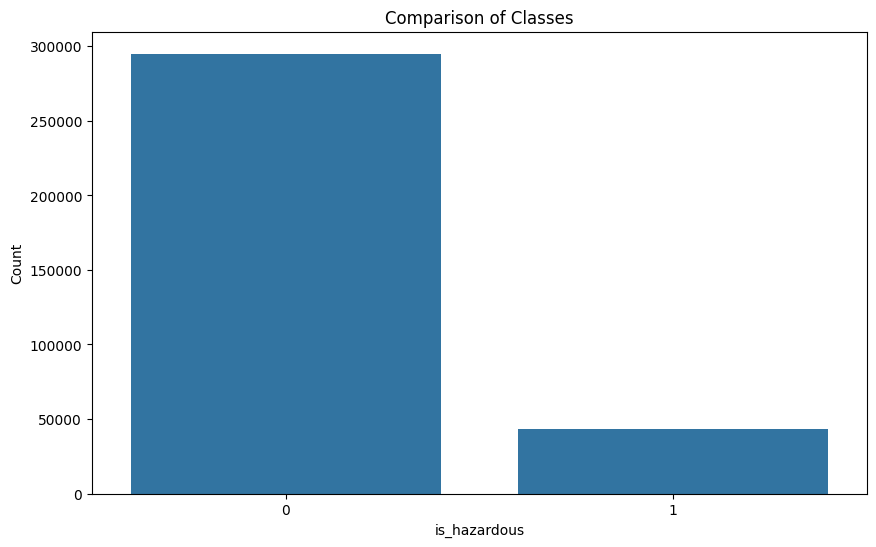

is_hazardous
0    295037
1     43162
Name: count, dtype: int64


In [ ]:
#Display the distribution of target variable
plt.figure(figsize=(10, 6))
sns.countplot(x='is_hazardous', data = rl_1)
plt.title('Comparison of Classes')
plt.xlabel('is_hazardous')
plt.ylabel('Count')
plt.show()
print(f"{rl_1['is_hazardous'].value_counts()}")

In [ ]:
#Split the features and target variable for training and target variable for training
x=rl_1.drop("is_hazardous",axis=1)
y=rl_1["is_hazardous"]

In [ ]:
from sklearn.impute import SimpleImputer

# Initial split to get train and test sets
X_train_full, X_test, y_train_full, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

# Further split the training set to get validation set
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.125, random_state=42)  # 0.125 x 0.8 = 0.10


**Cat Boost Classifier**

In [ ]:
!pip install catboost
from catboost import CatBoostClassifier, Pool
from catboost import CatBoostClassifier

# Prepare the data pools
train_pool = Pool(X_train, y_train)
val_pool = Pool(X_val, y_val)

# Define the parameter grid
param_grid = {
    'iterations': [100, 200],
    'depth': [4, 6],
    'learning_rate': [0.01, 0.1],
    'l2_leaf_reg': [1, 3],
}


# Initialize the CatBoostClassifier

cb = CatBoostClassifier(
    task_type='GPU',  # Use 'CPU' if you don't have a GPU
    verbose=0,
    random_seed=42
)


# Perform grid search
grid_search_result = cb.grid_search(param_grid, train_pool, cv=3, partition_random_seed=42, refit=True)

bestTest = 0.263096741
bestIteration = 99
0:	loss: 0.2630967	best: 0.2630967 (0)	total: 2.01s	remaining: 30.2s
bestTest = 0.2376513973
bestIteration = 99
1:	loss: 0.2376514	best: 0.2376514 (1)	total: 3.95s	remaining: 27.6s
bestTest = 0.2628883851
bestIteration = 99
2:	loss: 0.2628884	best: 0.2376514 (1)	total: 5.96s	remaining: 25.8s
bestTest = 0.2381217552
bestIteration = 98
3:	loss: 0.2381218	best: 0.2376514 (1)	total: 7.89s	remaining: 23.7s
bestTest = 0.2447404474
bestIteration = 199
4:	loss: 0.2447404	best: 0.2376514 (1)	total: 11.7s	remaining: 25.8s
bestTest = 0.2366087929
bestIteration = 199
5:	loss: 0.2366088	best: 0.2366088 (5)	total: 15.5s	remaining: 25.9s
bestTest = 0.2447194509
bestIteration = 199
6:	loss: 0.2447195	best: 0.2366088 (5)	total: 19.4s	remaining: 25s
bestTest = 0.2364120077
bestIteration = 199
7:	loss: 0.2364120	best: 0.2364120 (7)	total: 23.2s	remaining: 23.2s
bestTest = 0.2568247999
bestIteration = 99
8:	loss: 0.2568248	best: 0.2364120 (7)	total: 26.5s	remainin

In [ ]:
from sklearn.metrics import accuracy_score

print(f"Best parameters found: {grid_search_result['params']}")

# Evaluate on the test set
y_test_pred = cb.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {test_accuracy:.4f}')

Best parameters found: {'depth': 6, 'learning_rate': 0.1, 'l2_leaf_reg': 3, 'iterations': 200}
Validation Accuracy: 0.8874
Test Accuracy: 0.8853


**Random Forest Classifier**

In [ ]:

# Impute missing values with the mean
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)
X_test_imputed = imputer.transform(X_test)

y_train_np = y_train.values
y_val_np = y_val.values
y_test_np = y_test.values


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# Initialize RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train_imputed, y_train_np)

# Predict on validation set
y_val_pred = model.predict(X_val_imputed)

# Predict on test set
y_test_pred = model.predict(X_test_imputed)

# Calculate accuracy
val_accuracy = accuracy_score(y_val_np, y_val_pred)
test_accuracy = accuracy_score(y_test_np, y_test_pred)
print(f'Validation Accuracy: {val_accuracy:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

Validation Accuracy: 0.8692
Test Accuracy: 0.8657


**Tabnet Model**

In [ ]:
!pip install pytorch-tabnet
from pytorch_tabnet.tab_model import TabNetClassifier

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
# Initialize TabNetClassifier
clf = TabNetClassifier()

# Train the model
clf.fit(
    X_train=X_train_imputed, y_train=y_train_np,
    eval_set=[(X_val_imputed, y_val_np)],
    max_epochs=50,
    patience=10,
    batch_size=1024, virtual_batch_size=128
)

# Evaluate the model on the test set
y_pred = clf.predict(X_test_imputed)
test_accuracy = np.mean(y_pred == y_test_np)
print(f'Test Accuracy: {test_accuracy:.4f}')

epoch 0  | loss: 0.42013 | val_0_auc: 0.80222 |  0:00:06s
epoch 1  | loss: 0.37355 | val_0_auc: 0.78983 |  0:00:08s
epoch 2  | loss: 0.37129 | val_0_auc: 0.77415 |  0:00:10s
epoch 3  | loss: 0.37014 | val_0_auc: 0.79749 |  0:00:13s
epoch 4  | loss: 0.36875 | val_0_auc: 0.82754 |  0:00:16s
epoch 5  | loss: 0.36786 | val_0_auc: 0.84492 |  0:00:19s
epoch 6  | loss: 0.36824 | val_0_auc: 0.8584  |  0:00:22s
epoch 7  | loss: 0.36645 | val_0_auc: 0.86886 |  0:00:24s
epoch 8  | loss: 0.36815 | val_0_auc: 0.87226 |  0:00:27s
epoch 9  | loss: 0.36593 | val_0_auc: 0.87235 |  0:00:30s
epoch 10 | loss: 0.37079 | val_0_auc: 0.87671 |  0:00:33s
epoch 11 | loss: 0.36725 | val_0_auc: 0.87669 |  0:00:35s
epoch 12 | loss: 0.36756 | val_0_auc: 0.88009 |  0:00:38s
epoch 13 | loss: 0.36523 | val_0_auc: 0.87859 |  0:00:41s
epoch 14 | loss: 0.36482 | val_0_auc: 0.87948 |  0:00:44s
epoch 15 | loss: 0.36371 | val_0_auc: 0.87922 |  0:00:47s
epoch 16 | loss: 0.36557 | val_0_auc: 0.87967 |  0:00:49s
epoch 17 | los